In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_convergence
import warnings
from IPython import display

We'll continue to use the same datasets that we have been using throughout the course.

In [29]:
#Using the same datasets as used for linear regression in STAT303-2, 
#so that we can compare the non-linear models with linear regression
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990


In [30]:
X = train[['mileage','mpg','year','engineSize']]
Xtest = test[['mileage','mpg','year','engineSize']]
y = train['price']
ytest = test['price']

## LightGBM

LightGBM is a gradient boosting decision tree algorithm developed by Microsoft in 2017. LightGBM outperforms XGBoost in terms of compuational speed, and provides comparable accuracy in general. The following two key features in LightGBM that make it faster than XGBoost: 

**1. Gradient-based One-Side Sampling** (GOSS): Recall, in gradient boosting, we fit trees on the gradient of the loss function *(refer the gradient boosting algorithm in section 10.10.2 of the book, [Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/)):*

$$r_m = -\bigg[ \frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}  \bigg]_{f = f_{m-1}}. $$

Observations that correspond to relatively larger gradients contribute more to minimizing the loss function as compared to observations with smaller gradients. The algorithm down-samples the observations with small gradients, while selecting all the observations with large gradients. As observations with large gradients contribute the most to the reduction in loss function when considering a split, the accuracy of loss reduction estimate is maintained even with a reduced sample size. This leads to similar performance in terms of prediction accuracy while reducing computation speed due to reduction in sample size to fit trees.

**2. Exclusive feature bundling** (EFB): This is useful when there are a lot of predictors, but the predictor space is sparse, i.e., most of the values are zero for several predictors, and the predictors rarely take non-zero values simultaneously. This can typically happen in case of a lot of dummy variables in the data. In such a case, the predictors are bundled to create a single predictor. 

In the example below you can see that feature1 and feature2 are mutually exclusive. In order to achieve non overlapping buckets we add bundle size of feature1 to feature2. This makes sure that non zero data points of bundled features (feature1 and feature2) reside in different buckets. In feature_bundle buckets 1 to 4 contains non zero instances of feature1 and buckets 5,6 contain non zero instances of feature2 *([Reference](https://towardsdatascience.com/what-makes-lightgbm-lightning-fast-a27cf0d9785e))*. 

| feature1 | feature2 | feature_bundle |
| --- | --- | --- |
| 0 | 2 | 6 |
| 0 | 1 | 5 |
| 0 | 2 | 6 |
| 1 | 0 | 1 |
| 2 | 0 | 2 |
| 3 | 0 | 3 |
| 4 | 0 | 4 |

Read the [LightGBM paper](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) for more details.

### LightGBM for regression
Let us tune a lightGBM model for regression for our problem of predicting car price. We'll use the function [`LGBMRegressor`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html). For classification problems, [`LGBMClassifier`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html) can be used. Note that we are using the GOSS algorithm to downsample observations with smaller gradients. 

In [31]:
#K-fold cross validation to find optimal parameters for LightGBM regressor
start_time = time.time()
param_grid = {'num_leaves': [20, 31, 40],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 10, 100],
                'n_estimators':[100, 500, 1000],
                'reg_alpha': [0, 10, 100],
                'subsample': [0.5, 0.75, 1.0],
                'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=LGBMRegressor(boosting_type = 'goss'),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1, scoring='neg_root_mean_squared_error',
                             n_jobs=-1,random_state=1,
                             cv = cv)
optimal_params.fit(X,y)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation RMSE = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 0, 'num_leaves': 20, 'n_estimators': 1000, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Optimal cross validation R-squared =  -5670.309021679375
Time taken =  1  minutes


In [32]:
#RMSE based on the optimal parameter values of a LighGBM Regressor model
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(Xtest),ytest))

5614.374498193448

Note that downsampling of small-gradient observations leads to faster execution time, but potentially by compromising some accuracy. We can expect to improve the accuracy by increasing the `top_rate` or the `other_rate` hyperparameters, but at an increased computational cost. In the cross-validation below, we have increased the `top_rate` to 0.5 from the default value of 0.2.

In [33]:
#K-fold cross validation to find optimal parameters for LightGBM regressor
start_time = time.time()
param_grid = {'num_leaves': [20, 31, 40],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 10, 100],
                'n_estimators':[100, 500, 1000],
                'reg_alpha': [0, 10, 100],
                'subsample': [0.5, 0.75, 1.0],
                'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=LGBMRegressor(boosting_type = 'goss', top_rate = 0.5),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1, scoring='neg_root_mean_squared_error',
                             n_jobs=-1,random_state=1,
                             cv = cv)
optimal_params.fit(X,y)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation RMSE = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 100, 'num_leaves': 31, 'n_estimators': 500, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Optimal cross validation R-squared =  -5436.062435616846
Time taken =  1  minutes


In [34]:
#RMSE based on the optimal parameter values of a LighGBM Regressor model
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(Xtest),ytest))

5355.964600884197

Note that the cross-validated RMSE has reduced. However, this is at an increased computational expense. In the simulations below, we compare the time taken to train models with increasing values of the `top_rate` hyperparameter.

In [92]:
time_list = []
for i in range(50):
    start_time = time.time()
    model = LGBMRegressor(boosting_type = 'goss', top_rate = 0.2, n_jobs=-1).fit(X, y)
    time_list.append(time.time()-start_time)

In [93]:
time_list2 = []
for i in range(50):
    start_time = time.time()
    model = LGBMRegressor(boosting_type = 'goss', top_rate = 0.5, n_jobs=-1).fit(X, y)
    time_list2.append(time.time()-start_time)

In [94]:
time_list3 = []
for i in range(50):
    start_time = time.time()
    model = LGBMRegressor(boosting_type = 'goss', top_rate = 0.8, n_jobs=-1).fit(X, y)
    time_list3.append(time.time()-start_time)

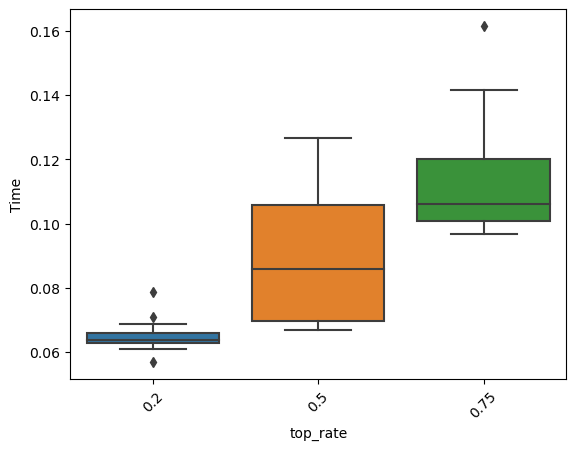

In [85]:
ax = sns.boxplot([time_list, time_list2, time_list3]);
ax.set_xticklabels([0.2, 0.5, 0.75]);
plt.ylabel('Time');
plt.xlabel('top_rate');
plt.xticks(rotation = 45);

### LightGBM vs XGBoost

LightGBM model took 2 minutes for a random search with 1000 fits as compared to 7 minutes for an XGBoost model with 1000 fits on the same data (as shown below). In terms of prediction accuracy, we observe that the accuracy of LightGBM on test *(unseen)* data is comparable to that of XGBoost.

In [14]:
#K-fold cross validation to find optimal parameters for XGBoost
start_time = time.time()
param_grid = {'max_depth': [4,6,8],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 1, 10],
                'n_estimators':[100, 500, 1000],
                'gamma': [0, 10, 100],
                'subsample': [0.5, 0.75, 1.0],
                'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1, scoring = 'neg_root_mean_squared_error',
                             n_jobs=-1,random_state = 1,
                             cv = cv)
optimal_params.fit(X,y)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 0.75, 'reg_lambda': 1, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 100, 'colsample_bytree': 1.0}
Optimal cross validation R-squared =  -5178.8689594137295
Time taken =  7  minutes


In [15]:
#RMSE based on the optimal parameter values
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(Xtest),ytest))

5420.661056398766

## CatBoost

CatBoost is a gradient boosting algorithm developed by Yandex *(Russian Google)* in 2017. Like LightGBM, CatBoost is also faster than XGBoost in training. However, unlike LightGBM, the authors have claimed that it outperforms both LightGBM and XGBoost in terms of prediction accuracy as well. 

The key feature of CatBoost that address the issue with the gradient boosting procedure is the idea of ordered boosting. Classic boosting algorithms are prone to overfitting on small/noisy datasets due to a problem known as prediction shift. Recall, in gradient boosting, we fit trees on the gradient of the loss function *(refer the gradient boosting algorithm in section 10.10.2 of the book, [Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/)):*

$$r_m = -\bigg[ \frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}  \bigg]_{f = f_{m-1}}. $$

When calculating the gradient estimate of an observation, these algorithms use the same observations that the model was built with, thus having no chances of experiencing unseen data. CatBoost, on the other hand, uses the concept of ordered boosting, a permutation-driven approach to train model on a subset of data while calculating residuals on another subset, thus preventing "target leakage" and overfitting. The residuals of an observation are computed based on a model developed on the previous observations, where the observations are randomly shuffled at each iteration, i.e., for each tree.

Thus, the gradient of the loss function is based on test *(unseen)* data, instead of the data on which the model has been trained, which improves the generalizability of the model, and avoids overfitting on train data.

The authors have also shown that CatBoost performs better than XGBoost and LightGBM without tuning, i.e., with default hyperparameter settings.

Read the [CatBoost paper](https://proceedings.neurips.cc/paper_files/paper/2018/file/14491b756b3a51daac41c24863285549-Paper.pdf) for more details.

Here is a good [blog](https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm) listing the key features of CatBoost.

### CatBoost for regression

We'll use the function [CatBoostRegressor](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor) for regression. For classification problems [CatBoostClassifier](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier) can be used.

Let us check the performance of `CatBoostRegressor()` without tuning, i.e., with default hyperparameter settings.

In [97]:
model_cat = CatBoostRegressor(verbose=0).fit(X, y)

In [103]:
cv = KFold(n_splits=5,shuffle=True,random_state=1)
np.mean(-cross_val_score(CatBoostRegressor(verbose=0), X, y, cv = cv, n_jobs = -1, 
                scoring='neg_root_mean_squared_error'))

5035.972129299527

In [99]:
np.sqrt(mean_squared_error(model_cat.predict(Xtest),ytest))

5288.82153844634

Even with default hyperparameter settings, CatBoost has outperformed both XGBoost and LightGBM in terms of cross-validated RMSE, and RMSE on test data for our example of predicting car prices.

### CatBoost vs XGBoost

Let us see the performance of XGBoost with default hyperparameter settings.

In [106]:
model_xgb = xgb.XGBRFRegressor().fit(X, y)
np.mean(-cross_val_score(xgb.XGBRFRegressor(), X, y, cv = cv, n_jobs = -1, 
                scoring='neg_root_mean_squared_error'))

6273.043859096154

In [107]:
np.sqrt(mean_squared_error(model_xgb.predict(Xtest),ytest))

6821.745153860935

XGBoost performance deteriorates showing that hyperparameter tuning is more important in XGBoost.

Let us see the performance of LightGBM with default hyperparameter settings.

In [112]:
model_lgbm = LGBMRegressor().fit(X, y)
np.mean(-cross_val_score(LGBMRegressor(), X, y, cv = cv, n_jobs = -1, 
                scoring='neg_root_mean_squared_error'))

5562.149251902867

In [113]:
np.sqrt(mean_squared_error(model_lgbm.predict(Xtest),ytest))

5494.0777923513515

LightGBM's default hyperparameter settings also seem to be more robust as compared to those of XGBoost.

### Tuning `CatBoostRegressor`

The CatBoost hyperparameters can be tuned just like the XGBoost hyperparameters. However, there is some difference in the hyperparameters of both the packages. For example, `reg_alpha` *(the L1 penalization on weights of leaves)* and `colsample_bytree` *(subsample ratio of columns when constructing each tree)* hyperparameters are not there in CatBoost.

In [121]:
#K-fold cross validation to find optimal parameters for CatBoost regressor
start_time = time.time()
param_grid = {'max_depth': [4,6,8, 10],
              'num_leaves': [20, 31, 40, 60],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 10, 100],
                'n_estimators':[500, 1000, 1500],
                'subsample': [0.5, 0.75, 1.0],
             'colsample_bylevel': [0.25, 0.5, 0.75, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=CatBoostRegressor(random_state=1, verbose=False, 
                            grow_policy='Lossguide'),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,random_state = 1, scoring='neg_root_mean_squared_error',
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X,y)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation RMSE = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 0.5, 'reg_lambda': 0, 'num_leaves': 40, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bylevel': 0.75}
Optimal cross validation RMSE =  -4993.129407810791
Time taken =  23  minutes


In [122]:
#RMSE based on the optimal parameter values
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(Xtest),ytest))

5249.434282204398

It takes 2 minutes to tune CatBoost, which is higher than LightGBM and lesser than XGBoost. CatBoost falls in between LightGBM and XGBoost in terms of speed. However, it is likely to be more accurate than XGBoost and LighGBM, and likely to require lesser tuning as compared to XGBoost.

In [ ]:
model = CatBoostRegressor(grow_policy='Lossguide') 

grid = {'num_leaves': Integer(4, 64),
              'learning_rate': Real(0.0001, 1.0),
               'reg_lambda':Real(0, 1e4),
                'n_estimators':Integer(2, 2000),
                'subsample': Real(0.1,1.0),
                'colsample_bylevel': Real(0.1, 1.0)}

kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
gcv = BayesSearchCV(model, search_spaces = grid, cv = kfold, n_iter = 200, random_state = 1,
                         scoring = 'neg_root_mean_squared_error', n_jobs = -1)
paras = list(gcv.search_spaces.keys())
paras.sort()

def monitor(optim_result):
    cv_values = pd.Series(optim_result['func_vals']).cummin()
    display.clear_output(wait = True)
    min_ind = pd.Series(optim_result['func_vals']).argmin()
    print(paras, "=", optim_result['x_iters'][min_ind], pd.Series(optim_result['func_vals']).min())
    sns.lineplot(cv_values)
    plt.show()
gcv.fit(X, y, callback = monitor)

In [130]:
#| echo: false

# import image module
from IPython.display import Image

# get the image
Image(url="./cat_tune.png", height=1000, width = 1000)

In [ ]:
# Optimal values obtained
#['colsample_bylevel', 'learning_rate', 'n_estimators', 'num_leaves', 'reg_lambda', 'subsample'] = 
#[0.3745508446405472, 0.1000958551500621, 2000, 11, 0.0, 0.3877212027881348] 5132.537839676808


### Tuning Tips 

Check the [documentation](https://catboost.ai/en/docs/references/training-parameters/common) for some tuning tips.

1. It is not recommended to use values greater than 64 for `num_leaves`, since it can significantly slow down the training process.

2. The maximum possible value of `max_depth` is 16.